In [2]:
!pip install googlemaps


  Using cached googlemaps-4.10.0-py3-none-any.whl


In [1]:
!pip install googlemaps networkx matplotlib


  Using cached googlemaps-4.10.0-py3-none-any.whl


In [31]:
API_KEY = 'XXXXXXX'

In [47]:
class Node:
    def __init__(self, name, coord):
        self.name = name  
        # Tuple: Coordinate as (latitude, longitude)
        self.coord = coord 
        # Neighbors dictionary: {neighbor Node : weight}
        self.neighbors = {}                   

    def __str__(self):
        # Build a list of (neighbor name, weight) pairs
        neighbors_list = [(neighbor.name, weight) for neighbor, weight in self.neighbors.items()]
        return f"{self.name} : {neighbors_list}"  

    def __repr__(self):
        # To just display the node name
        return f"Node({self.name})"             


In [48]:
class Graph:
    def __init__(self):
        # Dictionary to store nodes: {node name : Node object}
        self.nodes = {} 

    def add_node(self, name, coord):
        if name not in self.nodes:
            self.nodes[name] = Node(name, coord)  

    def remove_node(self, name):
        if name in self.nodes:
            node_to_remove = self.nodes.pop(name) 
            # Remove this node we just popped from the dictionary from all its neighbors' neighbor lists.
            # like if the structure is A : [('B', 6.1), ('C', 8.2)]; B : [('A', 6.1), ('C', 1.8)]; C : [('B', 1.8), ('A', 8.2)] and we remove A
            # then we alos remove A from its neighbours B and C , which is inside the neighbour list of B and C
            for neighbor in list(node_to_remove.neighbors.keys()):
                neighbor.neighbors.pop(node_to_remove, None)

    def add_edge(self, from_name, to_name, weight):
        if from_name in self.nodes and to_name in self.nodes:
            from_node = self.nodes[from_name] 
            to_node = self.nodes[to_name]    
            # Add to_node as neighbor of from_node
            from_node.neighbors[to_node] = weight  
            # Add from_node as neighbor of to_node (as its an undirected graph)
            to_node.neighbors[from_node] = weight  

    def remove_edge(self, from_name, to_name):
        if from_name in self.nodes and to_name in self.nodes:
            from_node = self.nodes[from_name] 
            to_node = self.nodes[to_name] 
            # Remove to_node from from_node's neighbors
            from_node.neighbors.pop(to_node, None)
            # Remove from_node from to_node's neighbors
            to_node.neighbors.pop(from_node, None) 

    def __str__(self):
        return "\n".join(str(node) for node in self.nodes.values()) 


In [51]:
def build_graph(points, edges, api_key):
    # Initialize Google Maps client with provided API key
    gmaps = googlemaps.Client(key=api_key)
    
    # Create an empty Graph object
    g = Graph()
    
    # Dictionary to store travel times (weights) between nodes
    edge_weights = {}

    # Add all nodes to the graph
    for name, coord in points.items():
        g.add_node(name, coord)  # Create a node for each location

    # Fetch travel times and add edges
    print("Fetching travel times and building the graph...")

    for u, v in edges:
        origin = points[u]         # Get coordinates of starting point
        destination = points[v]    # Get coordinates of ending point
        
        try:
            # Use Google Maps API to fetch driving time between two points
            result = gmaps.distance_matrix(origins=[origin], destinations=[destination], mode="driving")
            
            # Extract travel time in seconds, then convert to minutes
            time_min = result["rows"][0]["elements"][0]["duration"]["value"] / 60  
            time_min = round(time_min, 1)  # Round to 1 decimal place for neatness

            # Add an edge between the two nodes in the graph with the travel time as weight
            g.add_edge(u, v, time_min)

            # Save travel time in edge_weights dictionary for later use (like plotting)
            edge_weights[(u, v)] = time_min
            edge_weights[(v, u)] = time_min  # Since the graph is undirected

            # Print confirmation of the fetched travel time
            print(f"{u} → {v}: {time_min} min")

        except Exception as e:
            # If any error occurs during API call, print the error but continue building the graph
            print(f"Error fetching {u} → {v}: {e}")

    # Return the completed graph and the dictionary of edge weights
    return g, edge_weights


In [52]:
def draw_graph(points, edges, edge_weights):
    plt.figure(figsize=(8, 6))  # Set up the drawing canvas size

    # Draw all the edges first
    for (u, v), weight in edge_weights.items():
        if u < v:  # Only draw each edge once (undirected graph)
            x_coords = [points[u][1], points[v][1]]  # Get longitudes
            y_coords = [points[u][0], points[v][0]]  # Get latitudes
            plt.plot(x_coords, y_coords, 'k-', linewidth=1)  # Plot black line for edge
            
            # Place the weight (travel time) label at the midpoint of the edge
            mid_x = (x_coords[0] + x_coords[1]) / 2
            mid_y = (y_coords[0] + y_coords[1]) / 2
            plt.text(mid_x + 0.002, mid_y + 0.002, f"{weight}", fontsize=9, ha='center', color='black')

    # Draw all the nodes
    for label, (lat, lon) in points.items():
        if label == "A":
            color = "lightgreen"  # Start point node (special color)
        elif label == "E":
            color = "red"         # Destination node (special color)
        else:
            color = "lightblue"   # Regular nodes

        plt.scatter(lon, lat, color=color, s=300, edgecolors='black', zorder=3)  # Draw node
        plt.text(lon, lat + 0.001, label, ha='center', va='bottom', fontsize=12, weight='bold')  # Label the node

    # Set title and hide axes
    plt.title("Graph of Connected Locations with Travel Time (minutes)", pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw the static Google map with nodes and paths
def display_map(points, edges, api_key):
    base_url = "https://maps.googleapis.com/maps/api/staticmap?size=800x600&maptype=roadmap"
    url = base_url

    # Add node markers
    for label, (lat, lon) in points.items():
        if label == "A":
            url += f"&markers=color:green%7Clabel:{label}%7C{lat},{lon}"  # Green marker for start node
        elif label == "E":
            url += f"&markers=color:red%7Clabel:{label}%7C{lat},{lon}"    # Red marker for destination node
        else:
            url += f"&markers=color:blue%7Clabel:{label}%7C{lat},{lon}"   # Blue markers for regular nodes

    # Add paths (edges) between nodes
    for u, v in edges:
        lat1, lon1 = points[u]
        lat2, lon2 = points[v]
        url += f"&path=color:0x000000ff|weight:2|{lat1},{lon1}|{lat2},{lon2}"  # Draw blue paths

    # Attach the API key at the end
    url += f"&key={api_key}"

    # Fetch the map from Google and display it
    response = requests.get(url)
    display(Image(response.content))


Fetching travel times and building the graph...
A → B: 6.1 min
A → I: 8.2 min
A → H: 8.7 min
B → C: 1.8 min
B → H: 4.2 min
C → D: 3.7 min
C → G: 4.1 min
D → G: 4.4 min
D → E: 5.7 min
E → F: 6.3 min
F → I: 9.4 min
G → H: 4.8 min
G → E: 6.5 min
H → I: 7.8 min
G → I: 9.1 min
G → F: 6.4 min


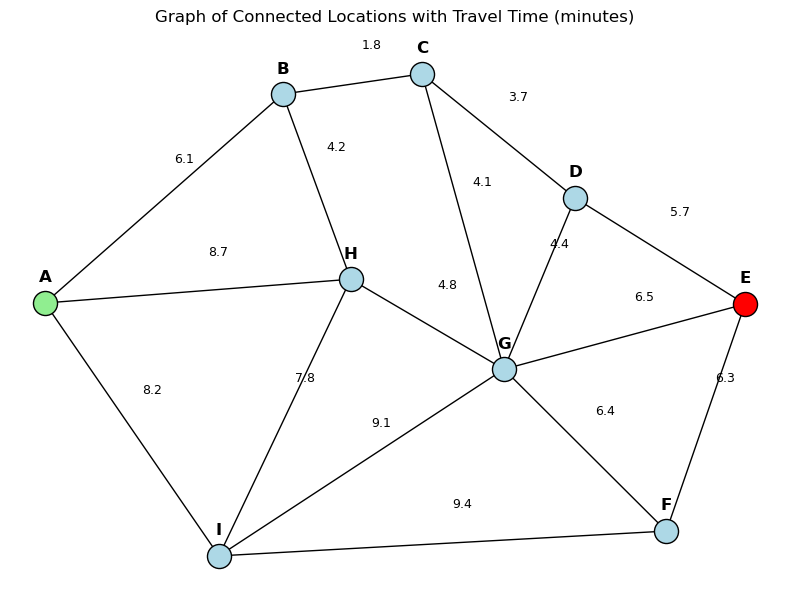

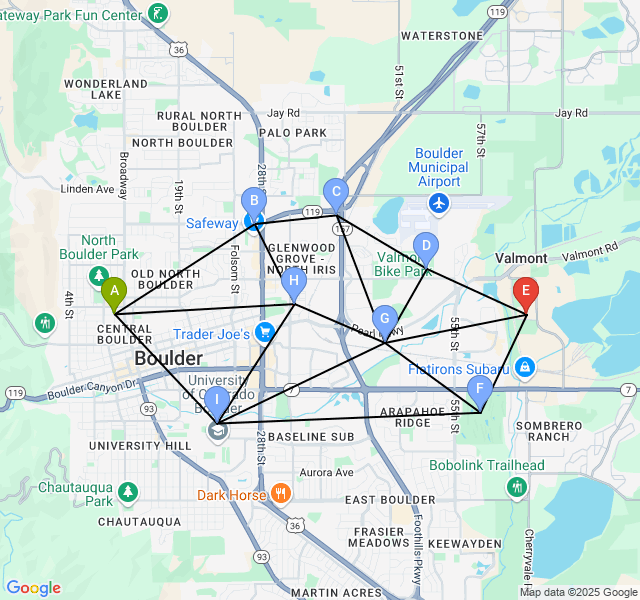

A : [('B', 6.1), ('I', 8.2), ('H', 8.7)]
B : [('A', 6.1), ('C', 1.8), ('H', 4.2)]
C : [('B', 1.8), ('D', 3.7), ('G', 4.1)]
D : [('C', 3.7), ('G', 4.4), ('E', 5.7)]
E : [('D', 5.7), ('F', 6.3), ('G', 6.5)]
F : [('E', 6.3), ('I', 9.4), ('G', 6.4)]
G : [('C', 4.1), ('D', 4.4), ('H', 4.8), ('E', 6.5), ('I', 9.1), ('F', 6.4)]
H : [('A', 8.7), ('B', 4.2), ('G', 4.8), ('I', 7.8)]
I : [('A', 8.2), ('F', 9.4), ('H', 7.8), ('G', 9.1)]


In [57]:
# Points and Edges
points = {
    "A": (40.02461, -105.28381),
    "B": (40.03647, -105.25979),
    "C": (40.03762, -105.24572),
    "D": (40.03057, -105.23023),
    "E": (40.02455, -105.21307),
    "F": (40.01166, -105.22102),
    "G": (40.02085, -105.23743),
    "H": (40.02596, -105.25292),
    "I": (40.01025, -105.26623),
}

edges = [
    ("A", "B"), ("A", "I"), ("A", "H"),
    ("B", "C"), ("B", "H"),
    ("C", "D"), ("C", "G"),
    ("D", "G"), ("D", "E"),
    ("E", "F"), ("F", "I"),
    ("G", "H"), ("G", "E"),
    ("H", "I"), ("G", "I"), ("G", "F"),
]


# Build the graph
graph, edge_weights = build_graph(points, edges, API_KEY)

# Draw the matplotlib graph
draw_graph(points, edges, edge_weights)

# Display the Google Static Map
display_map(points, edges, API_KEY)

# Print the graph structure
print(graph)


In [74]:
import heapq  

def dijkstra(graph, start, end=None):
    # Initialize a dictionary to store cost and full path (pred) for each node
    node_data = {name: {'cost': float('inf'), 'pred': []} for name in graph.nodes}
    
    # Cost to reach start node is zero
    node_data[start]['cost'] = 0 
    
    # Start node has no predecessor initially
    node_data[start]['pred'] = [] 

    # Set to keep track of visited nodes
    visited = set() 

    # Initialize the min-heap with (cost, node_name) starting from the source
    min_heap = [(0, start)]

    while min_heap:
        # Pop the node with the smallest cost from the heap
        current_cost, current_node = heapq.heappop(min_heap)

        # If node is already visited then skip
        if current_node in visited:
            continue

        # Mark the node as visited
        visited.add(current_node)

        # If we have reached the end node, stop early
        if end is not None and current_node == end:
            break

        # Visit each neighbor of the current node
        for neighbor_node, weight in graph.nodes[current_node].neighbors.items():
            neighbor_name = neighbor_node.name

            if neighbor_name not in visited:
                new_cost = current_cost + weight  # Calculate the cost to reach the neighbor

                # If this cost is lesser than previously cost, update neighbor's cost and path
                if new_cost < node_data[neighbor_name]['cost']:
                    node_data[neighbor_name]['cost'] = new_cost
                    node_data[neighbor_name]['pred'] = node_data[current_node]['pred'] + [current_node]

                    # Push updated neighbor into the heap
                    heapq.heappush(min_heap, (new_cost, neighbor_name))

    # Making sure to add the end node in the shortest path 
    if end is not None:
        shortest_path = node_data[end]['pred'] + [end]
        return node_data, shortest_path
    else:
        return node_data, None


In [77]:
node_data, shortest_path = dijkstra(graph, start='A', end='E')

# Print cost
print(f"Shortest cost from A to F is {node_data['F']['cost']} min")

# Print path
print("Shortest path:", " -> ".join(shortest_path))


Shortest cost from A to F is 17.6 min
Shortest path: A -> B -> C -> D -> E
